## Analysing GFP Expression
This notebook presents an automated data processing of `.csv` files obtained from the `ImageJ` macros. 
This requires both the image sources (raw GFP images) and the csv files derived from the macro.

Take note that this script requires you to specify the `strain` of the *C. elegans* at the beginning as well as the `color_scheme` to be used for the visualization of thre results later.

### Specify the strain of *C. elegans*
Select below the strain of *C. elegans* to be analyzed. Also include the `color_scheme` to be applied for the succeeding data visualization.
1. **LX929**    : GFP-expressed *cholinergic* neurons

2. **BZ555**    : GFP-expressed *dopaminergic* neurons

3. **EG1428**   : GFP-expressed *GABAergic* neurons

4. **OH441**    : GFP-expressed *pan-neuronal*

In [2]:
## 1. LX929 : GFP-expressed cholinergic neurons
# strain = 'LX929'
# img_type = 'png'
# gradient_scheme = ["#0f5691", "#1a8f97", "#24c79e", "#2effa4"]


## 2. BZ555 : GFP-expressed dopaminergic neurons
# strain = 'BZ555'
# img_type = 'tif'
# gradient_scheme = ["#0f8d91", "#4ab46f", "#84d94f", "#bdff2e"]

# ##3. EG1428 : GFP-expressed GABA-ergic neurons
# strain = 'EG1428'
# img_type = 'tif'
# gradient_scheme = ["#2d2ab8", "#733bcc", "#b64cdf", "#fa5cf2"]

##4. OH441 : GFP-expressed pan-neuronal
strain = 'UA57'
img_type = 'png'
# gradient_scheme = ["#ff9500", "#f2700e", "#e64c1b", "#d92828"] 

gradient_scheme = ["#2effa4", "#38cfb2", "#41a0bf", "#4a71cc"] ## all
print(strain)



UA57



#### Import and prepare files

In [23]:
import os
import glob
import numpy as np
import pandas as pd

## Folder names and location
infolder = 'Results - Untreated'
imgsrc = 'Untreated with H2O2'

## List of working files
csvfiles = np.sort([f for f in glob.glob(os.path.join(infolder, "*.csv"))])
imgfiles = np.sort([f for f in glob.glob(os.path.join(imgsrc, "*"))])

print(csvfiles, len(csvfiles))
print(imgfiles, len(imgfiles))

['With Treatment - Results/EGCG 1 Results.csv'
 'With Treatment - Results/EGCG 2 Results.csv'
 'With Treatment - Results/EGCG 3 Results.csv'
 'With Treatment - Results/EGCG 4 Results.csv'
 'With Treatment - Results/OP50 1 Results.csv'
 'With Treatment - Results/OP50 2 Results.csv'
 'With Treatment - Results/OP50 3 Results.csv'
 'With Treatment - Results/OP50 4 Results.csv'
 'With Treatment - Results/OP50 5 Results.csv'
 'With Treatment - Results/OP50 6 Results.csv'
 'With Treatment - Results/OP50 7 Results.csv'] 11
['Treated with H2O2/EGCG 1.png' 'Treated with H2O2/EGCG 2.png'
 'Treated with H2O2/EGCG 3.png' 'Treated with H2O2/EGCG 4.png'
 'Treated with H2O2/OP50 1.png' 'Treated with H2O2/OP50 2.png'
 'Treated with H2O2/OP50 3.png' 'Treated with H2O2/OP50 4.png'
 'Treated with H2O2/OP50 5.png' 'Treated with H2O2/OP50 6.png'
 'Treated with H2O2/OP50 7.png'] 11


In [24]:
## Define controls and treatment
## Controls and treatment
control = {'DMSO':None, 'OP50':None, 'EGCG':None,
           'It L':None, 'It M':None, 'It H':None,
           'Lt L':None, 'Lt M':None, 'Lt H':None,
           'Kp L':None, 'Kp M':None, 'Kp H':None,
           'Sb L':None, 'Sb M':None, 'Sb H':None}
            
print(control, [*control.keys()])

{'DMSO': None, 'OP50': None, 'EGCG': None, 'It L': None, 'It M': None, 'It H': None, 'Lt L': None, 'Lt M': None, 'Lt H': None, 'Kp L': None, 'Kp M': None, 'Kp H': None, 'Sb L': None, 'Sb M': None, 'Sb H': None} ['DMSO', 'OP50', 'EGCG', 'It L', 'It M', 'It H', 'Lt L', 'Lt M', 'Lt H', 'Kp L', 'Kp M', 'Kp H', 'Sb L', 'Sb M', 'Sb H']


## Controls and Treatment
We prepare the necessary dataframe for both controls and treatment. The function `to_melted_dataframe` transforms the raw `imglist` and `csvlist` into a dataframe that consists of the `Area`, `RawIntDen`, `control` and `time` per sample. We then compute for the mean and the standard error of each time point, and visualize the results using `ggplot`. 

In [25]:
## Define function for controls and treatment
import cv2

def to_melted_dataframe(type, cols = ["control", "time", "RawIntDen"], csvfiles = csvfiles, imgfiles = imgfiles, img_type="png", save=True, filepath = 'controls.csv'):
    ''''
    Returns melted dataframe which contains the cols from csvfiles for selected type i.e. control or treatment.
    Inputs:
            type        : control or treatment dictionary
            cols        : column name i.e. default
            csvfiles    : list of csv files
            imgfiles    : list of images 
            img_type    : file extension of the raw images e.g. png, tif
            filepath    : full path (.csv) of the dataframe, set save = True by default
    Output:
            sgdf        : Dataframe with cols of the type i.e. control/treatment
    '''

    sgdf = pd.DataFrame(columns=cols)
    for ctrlname in [*type.keys()]:
        ctrls = [f for f in csvfiles if f.__contains__(ctrlname)]
        for f in ctrls:
            if f.__contains__('DMSO'):
                ntrial = f.split(" ")[1]
            elif f.__contains__('EGCG'):
                ntrial = f.split(" ")[1]
            elif f.__contains__('OP50'):
                ntrial = f.split(" ")[1]
            else:
                ntrial = f.split(" ")[2]

            df = pd.read_csv(f)
            ## Extract image
            imgf = f.replace(" Results.csv", "."+img_type).split("/")[1]

            ## Filtering
            try:
                imgff = [f for f in imgfiles if f.__contains__(imgf)][0]
                img = cv2.imread(imgff)
                G = img[:,:,1]
                G = G[G>0] ## Remove zeroes first
                mean_intensity = np.mean(G) ## Take mean
            except TypeError:
                raise TypeError
    
            ## Filter mean > mean_intensity and area > 1
            sdf = df[(df.Mean > mean_intensity)]
            sdf = sdf[(sdf.Area > 1)]

            ## Sanity check if this part here gets filtered
            # if len(df)!=len(sdf):
            #     print("Filtered: ", imgf, len(df), len(sdf))       
             
            sgdf = pd.concat([sgdf, pd.DataFrame({
                                        "Mean": sdf.Mean,
                                        "Area": sdf.Area,
                                        "RawIntDen":sdf.RawIntDen, 
                                        "control":[ctrlname]*len(sdf.RawIntDen),
                                        "time": [ntrial]*len(sdf.RawIntDen)})], ignore_index=True)

    sgdf.RawIntDen = sgdf.RawIntDen.astype('float') 
    if save:
        sgdf.to_csv(filepath)
    return sgdf
    
    

## 1. Controls

In [26]:
import os

## Apply the function to the control
ctrl_filepath = os.path.join(infolder+'.csv')
sgdf = to_melted_dataframe(control, csvfiles = csvfiles, imgfiles = imgfiles, img_type=img_type, save=True, filepath = ctrl_filepath)
print("Control: ", sgdf.control.unique())
sgdf.head(10)


Control:  ['OP50' 'EGCG']


,control,time,RawIntDen,Mean,Area
0,OP50,Treatment,880.0,73.333,12.0
1,OP50,Treatment,5508.0,110.160,50.0
2,OP50,Treatment,2696.0,103.692,26.0
3,OP50,Treatment,314422.0,131.612,2389.0
4,OP50,Treatment,7338.0,83.386,88.0
5,OP50,Treatment,98586.0,145.193,679.0
6,OP50,Treatment,614.0,122.800,5.0
7,OP50,Treatment,17628.0,111.570,158.0
8,OP50,Treatment,295318.0,123.823,2385.0
9,OP50,Treatment,5630.0,134.048,42.0


#### 1.1 Check normality assumption.
Convert raw to log if necessary to apply ANOVA. Test for normality using Shapiro-Wilk test. 

Null hypothesis: The data come from a normal distribution.
Main take away: Not normal.

In [737]:
import matplotlib.pyplot as plt 
import numpy as np
import pingouin as pg

from scipy.stats import shapiro, gamma, boxcox, fligner, norm, yeojohnson,norm, probplot

for ctrlname in [*control.keys()]:
    dmso = sgdf[sgdf.control == ctrlname].reset_index()
    print(ctrlname)
    fitted_data, fitted_lambda = yeojohnson(dmso.RawIntDen)
    dmso["logRawIntDen"] = np.log(dmso.RawIntDen[dmso.RawIntDen > 0])
    print("[**] %s : p_raw = %e | p_log = %e | p_log = %e" %(ctrlname, shapiro(dmso["RawIntDen"].to_list())[1], shapiro(dmso["logRawIntDen"].to_list())[1], shapiro(fitted_data)[1]))


DMSO
[**] DMSO : p_raw = 5.675428e-28 | p_log = 5.982593e-08 | p_log = 2.074449e-04
OP50
[**] OP50 : p_raw = 2.689493e-27 | p_log = 3.737388e-09 | p_log = 1.160684e-05
Metab
[**] Metab : p_raw = 3.555886e-21 | p_log = 4.014575e-07 | p_log = 1.565017e-04
EGCG
[**] EGCG : p_raw = 2.705886e-28 | p_log = 2.368206e-09 | p_log = 3.803374e-03


                W          pval  equal_var
levene  77.511092  1.243292e-17      False


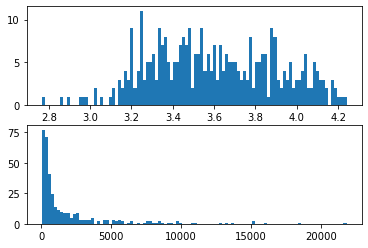

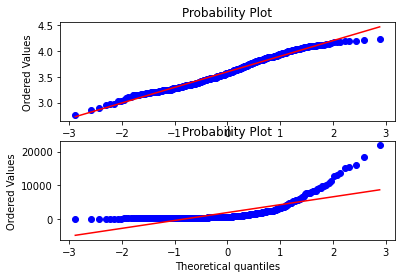

In [738]:
## Apply Levene's test for homogeneity of variance
dmso, _ = boxcox(sgdf[(sgdf.control == "DMSO")].reset_index().RawIntDen)
egcg, _ = boxcox(sgdf[(sgdf.control == "EGCG")].reset_index().RawIntDen)
metab, _ = boxcox(sgdf[(sgdf.control == "Metab")].reset_index().RawIntDen)
op50, _ = boxcox(sgdf[(sgdf.control == "OP50")].reset_index().RawIntDen)
print(pg.homoscedasticity([dmso, egcg], alpha=.05))

fig2 = plt.figure()
ax3 = fig2.add_subplot(211)
ax3.hist(dmso.tolist(), bins=100)
ax4 = fig2.add_subplot(212)
ax4.hist(sgdf[(sgdf.control == "DMSO")].reset_index().RawIntDen.to_list(),bins=100)



fig = plt.figure()
ax1 = fig.add_subplot(211)
prob = probplot(dmso, dist=norm, plot=ax1)
ax2 = fig.add_subplot(212)
prob = probplot(sgdf[(sgdf.control == "DMSO")].reset_index().RawIntDen, dist=norm, plot=ax2)

#### 1.2 Visualize Raw Intensity data

In [739]:
from plotnine import *

## 1. Prepare dataset
sgdf["RawIntDen_boxcox"],_ = boxcox(sgdf.RawIntDen)

ctrl_df = sgdf.groupby(['control', 'time']).agg({'RawIntDen': ['mean','sem'], 'Mean': ['mean'], 'Area': ['mean']}).reset_index()
ctrl_df.columns = ctrl_df.columns.map('_'.join)
ctrl_df = ctrl_df.rename(columns={'control_': 'control', 'time_': 'time'})
ctrl_df['RawIntDen_upper'] = ctrl_df.RawIntDen_mean + ctrl_df.RawIntDen_sem
ctrl_df['RawIntDen_lower'] = ctrl_df.RawIntDen_mean - ctrl_df.RawIntDen_sem
ctrl_df

ctrl_df2 = sgdf.groupby(['control', 'time']).agg({'RawIntDen_boxcox': ['mean','sem'], 'Mean': ['mean'], 'Area': ['mean']}).reset_index()
ctrl_df2.columns = ctrl_df2.columns.map('_'.join)
ctrl_df2 = ctrl_df2.rename(columns={'control_': 'control', 'time_': 'time'})
ctrl_df2['RawIntDen_boxcox_upper'] = ctrl_df2.RawIntDen_boxcox_mean + ctrl_df2.RawIntDen_boxcox_sem
ctrl_df2['RawIntDen_boxcox_lower'] = ctrl_df2.RawIntDen_boxcox_mean - ctrl_df2.RawIntDen_boxcox_sem
ctrl_df2

,control,time,RawIntDen_boxcox_mean,RawIntDen_boxcox_sem,Mean_mean,Area_mean,RawIntDen_boxcox_upper,RawIntDen_boxcox_lower
0,DMSO,t0,3.474379,0.027337,92.755196,20.568627,3.501716,3.447043
1,DMSO,t3,3.447016,0.029247,85.086919,16.824324,3.476263,3.417768
2,DMSO,t6,3.379725,0.031218,62.682897,18.724138,3.410943,3.348507
3,DMSO,t9,3.446314,0.026354,73.718045,22.247191,3.472668,3.419961
4,EGCG,t0,3.458228,0.029412,89.373667,23.490196,3.487641,3.428816
5,EGCG,t3,3.514939,0.035804,95.435906,30.830189,3.550743,3.479134
6,EGCG,t6,3.385016,0.022643,79.877839,13.781609,3.407659,3.362373
7,EGCG,t9,3.459777,0.038488,81.265091,19.454545,3.498265,3.421289
8,Metab,t0,3.550009,0.037854,105.547531,25.877551,3.587863,3.512155
9,Metab,t3,3.423741,0.037315,65.086833,17.976190,3.461056,3.386426


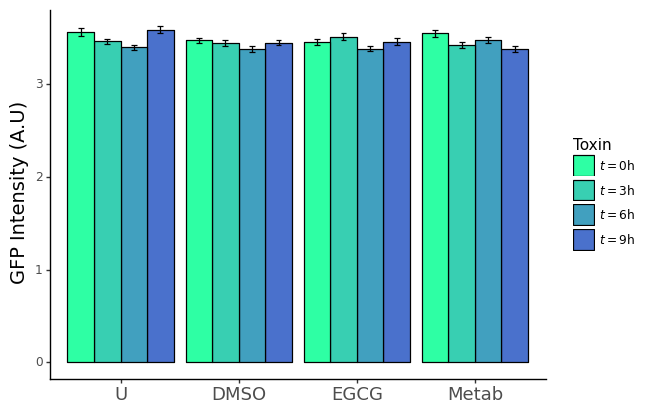

<ggplot: (328639100)>

In [740]:
## 2. Visualize
color_scheme = ["#003f5c",  "#ffa600", "#58508d", "#bc5090", "#ff6361"]
ctrl_df.loc[ctrl_df.control=='OP50', 'control'] = 'U'

f = (
        ggplot(ctrl_df, aes(x='control', y='RawIntDen_mean', fill='time')) +\
                theme_classic()  + labs(x = '', y = 'GFP Intensity (A.U)') +\
                theme(axis_title_y = element_text(size = 14), axis_text_x=element_text(size=13) ) +\
                geom_bar(position=position_dodge(), stat="identity", colour='black') +\
                geom_errorbar(aes(ymin='RawIntDen_lower', ymax='RawIntDen_upper'), width=.2,position=position_dodge(.9)) +\
                scale_fill_manual(name = 'Toxin', values=gradient_scheme, labels=['$t = 0$h', '$t = 3$h', '$t = 6$h', '$t = 9$h']) +\
                scale_x_discrete(limits=("U","DMSO","EGCG", "Metab"))
    )
    
f

# For BoxCox tranformed data
ctrl_df2.loc[ctrl_df2.control=='OP50', 'control'] = 'U'
f2 = (
        ggplot(ctrl_df2, aes(x='control', y='RawIntDen_boxcox_mean', fill='time')) +\
                theme_classic()  + labs(x = '', y = 'GFP Intensity (A.U)') +\
                theme(axis_title_y = element_text(size = 14), axis_text_x=element_text(size=13) ) +\
                geom_bar(position=position_dodge(), stat="identity", colour='black') +\
                geom_errorbar(aes(ymin='RawIntDen_boxcox_lower', ymax='RawIntDen_boxcox_upper'), width=.2,position=position_dodge(.9)) +\
                scale_fill_manual(name = 'Toxin', values=gradient_scheme, labels=['$t = 0$h', '$t = 3$h', '$t = 6$h', '$t = 9$h']) +\
                scale_x_discrete(limits=("U","DMSO","EGCG", "Metab"))
    )
    
f2

In [741]:
## Saving the graph
f.save(filename = '%s-Control.png'%strain, height=4.5, width=12, units = 'in', dpi=600, path=os.path.join(strain))
print("Saved file.")

/Users/jcbacong/opt/miniconda3/envs/meowth/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 12 x 4.5 in image.
/Users/jcbacong/opt/miniconda3/envs/meowth/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: OH441/OH441-Control.png


Saved file.


## 2. Treatment

In [50]:
import os

## Apply the function to the control
tx_filepath = os.path.join(infolder+'-treatment.csv')
tgdf = to_melted_dataframe(treatment, csvfiles = csvfiles, imgfiles = imgfiles, img_type=img_type, save=True, filepath = tx_filepath)
print("Treatment: ", tgdf.control.unique())
tgdf.head(10)

Treatment:  ['fwl' 'fwm' 'fwh' 'lwl' 'lwm' 'lwh' 'fll' 'flm' 'flh' 'lll' 'llm' 'llh']


,control,time,RawIntDen,Mean,Area
0,fwl,1,82.0,13.667,6.0
1,fwl,1,72.0,14.400,5.0
2,fwl,1,118.0,23.600,5.0
3,fwl,1,76.0,12.667,6.0
4,fwl,1,98.0,19.600,5.0
5,fwl,1,242.0,18.615,13.0
6,fwl,1,108.0,18.000,6.0
7,fwl,1,100.0,20.000,5.0
8,fwl,1,162.0,14.727,11.0
9,fwl,1,80.0,16.000,5.0


#### 2.1 Check normality assumption
Use Shapiro-Wilk normality test. 
Main results: Not normal.

In [743]:
import matplotlib.pyplot as plt 
import numpy as np

from scipy.stats import shapiro

for txname in [*treatment.keys()]:
    dmso = tgdf[tgdf.control == txname].reset_index()

    dmso["logRawIntDen"] = np.log(dmso.RawIntDen[dmso.RawIntDen > 0])
    print("[**] %s : p_raw = %e | p_log = %e" %(txname, shapiro(dmso["RawIntDen"].to_list())[1], shapiro(dmso["logRawIntDen"].to_list())[1]))


[**] fwl : p_raw = 2.001701e-24 | p_log = 6.906518e-06
[**] fwm : p_raw = 6.278730e-29 | p_log = 1.395156e-08
[**] fwh : p_raw = 1.876073e-30 | p_log = 1.280234e-10
[**] lwl : p_raw = 4.516568e-25 | p_log = 8.685505e-08
[**] lwm : p_raw = 6.134584e-27 | p_log = 6.190799e-09
[**] lwh : p_raw = 1.173668e-24 | p_log = 9.524445e-07
[**] fll : p_raw = 1.964192e-25 | p_log = 1.399095e-08
[**] flm : p_raw = 1.284656e-32 | p_log = 2.948926e-12
[**] flh : p_raw = 1.681618e-26 | p_log = 3.857429e-07
[**] lll : p_raw = 7.566597e-30 | p_log = 5.533402e-08
[**] llm : p_raw = 8.149885e-27 | p_log = 2.223275e-07
[**] llh : p_raw = 3.927562e-26 | p_log = 2.653286e-09


#### 2.2 Visualize Raw Intensity data

In [744]:
from plotnine import *

## 1. Prepare dataset
tx_df = tgdf.groupby(['control', 'time']).agg({'RawIntDen': ['mean','sem'], 'Mean': ['mean'], 'Area': ['mean']}).reset_index()
tx_df.columns = tx_df.columns.map('_'.join)
tx_df = tx_df.rename(columns={'control_': 'control', 'time_': 'time'})
tx_df['RawIntDen_upper'] = tx_df.RawIntDen_mean + tx_df.RawIntDen_sem
tx_df['RawIntDen_lower'] = tx_df.RawIntDen_mean - tx_df.RawIntDen_sem
tx_df.head(10)


,control,time,RawIntDen_mean,RawIntDen_sem,Mean_mean,Area_mean,RawIntDen_upper,RawIntDen_lower
0,flh,t0,3007.836066,690.231981,109.515148,23.852459,3698.068047,2317.604084
1,flh,t3,1046.186916,163.244812,61.276318,15.420561,1209.431728,882.942104
2,flh,t6,1803.027027,432.905098,71.839730,22.189189,2235.932125,1370.121929
3,flh,t9,4511.944444,769.921697,122.678417,28.861111,5281.866141,3742.022748
4,fll,t0,3215.642105,592.817497,81.038979,28.715789,3808.459602,2622.824609
5,fll,t3,1564.602410,273.212519,73.287048,18.192771,1837.814929,1291.389891
6,fll,t6,2757.134615,742.513926,81.579615,26.942308,3499.648541,2014.620690
7,fll,t9,2363.619048,868.958009,56.957429,30.000000,3232.577057,1494.661039
8,flm,t0,2749.800000,544.783089,89.221716,24.284211,3294.583089,2205.016911
9,flm,t3,1173.654321,227.633973,69.749741,15.234568,1401.288294,946.020348


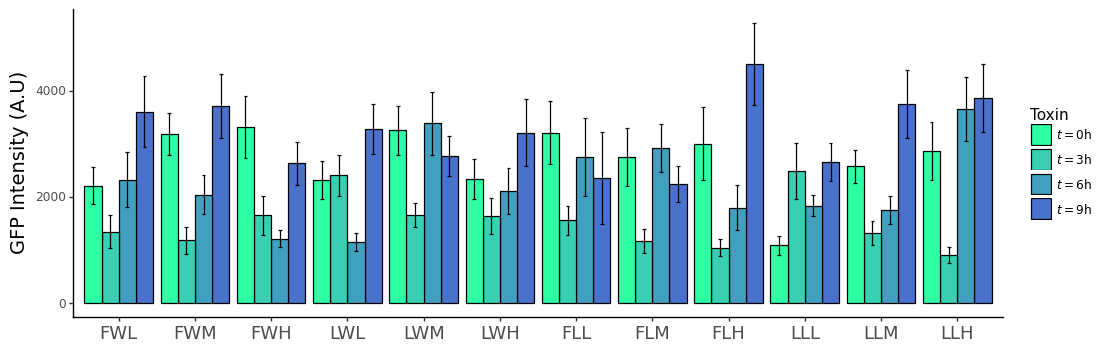

<ggplot: (323714699)>

In [745]:
## 2. Visualize

tx_df.control = tx_df.control.apply(lambda x: x.upper())


g = (
        ggplot(tx_df, aes(x='control', y='RawIntDen_mean', fill='time')) +\
                theme_classic()  + labs(x = '', y = 'GFP Intensity (A.U)') +\
                theme(figure_size=(12, 4), axis_title_y = element_text(size = 14), axis_text_x=element_text(size=13) ) +\
                geom_bar(position=position_dodge(), stat="identity", colour='black') +\
                geom_errorbar(aes(ymin='RawIntDen_lower', ymax='RawIntDen_upper'), width=.2,position=position_dodge(.9)) +\
                scale_fill_manual(name = 'Toxin', values=gradient_scheme, labels=['$t = 0$h', '$t = 3$h', '$t = 6$h', '$t = 9$h']) +\
                scale_x_discrete(limits=[x.upper() for x in [*treatment.keys()]])
    )
    
g

In [746]:
## Saving the graph
g.save(filename = '%s-Treatment.png'%strain, height=4.5, width=12, units = 'in', dpi=600, path=os.path.join(strain))
print("Saved file.")

/Users/jcbacong/opt/miniconda3/envs/meowth/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 12 x 4.5 in image.
/Users/jcbacong/opt/miniconda3/envs/meowth/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: OH441/OH441-Treatment.png


Saved file.


## 3. Control vs Treatment
Combine two figures to compare controls vs treated. 

In [747]:
## 1. Add a column = type either control, field wine, lab wine, field lees or lab lees

def rename_wine_or_lees(x):
    if x.startswith("FW"):
        return "Field Wine"
    elif x.startswith("LW"):
        return "Lab Wine"
    elif x.startswith("LL"):
        return "Lab Lees"
    elif x.startswith("FL"):
        return "Field Lees"
    else:
        return x

tandc = ['U', 'DMSO', 'EGCG', 'Metab', 
            'FWL', 'FWM', 'FWH',
            'LWL', 'LWM', 'LWH',
            'FLL', 'FLM', 'FLH',
            'LLL', 'LLM', 'LLH']
            

ctrl_df['type'] = 'Control'
tx_df['type'] = tx_df.control.apply(lambda x: rename_wine_or_lees(x))
all_df = pd.concat([ctrl_df, tx_df], axis=0).reset_index().drop("index", axis=1)
all_df['control_index'] = pd.Categorical(
                            all_df['control'], 
                            categories=tandc, 
                            ordered=True)
all_df['type'] = pd.Categorical(
                            all_df['type'], 
                            categories=["Control", "Field Wine", "Lab Wine", "Field Lees", "Lab Lees"], 
                            ordered=True)
                            
all_df.sort_values('control_index', inplace=True)
all_df

,control,time,RawIntDen_mean,RawIntDen_sem,Mean_mean,Area_mean,RawIntDen_upper,RawIntDen_lower,type,control_index
13,U,t3,2422.991150,374.931079,91.704035,21.522124,2797.922230,2048.060071,Control,U
15,U,t9,4826.761194,784.692401,117.277313,32.194030,5611.453595,4042.068793,Control,U
14,U,t6,2050.445312,370.444336,66.043078,22.882812,2420.889648,1680.000977,Control,U
12,U,t0,3889.513514,901.632670,107.074919,29.648649,4791.146183,2987.880844,Control,U
0,DMSO,t0,2370.372549,341.369688,92.755196,20.568627,2711.742237,2029.002861,Control,DMSO
...,...,...,...,...,...,...,...,...,...,...
48,LLM,t0,2579.979452,312.956654,94.719267,23.054795,2892.936106,2267.022798,Lab Lees,LLM
40,LLH,t0,2866.172840,546.003934,115.434000,20.913580,3412.176773,2320.168906,Lab Lees,LLH
43,LLH,t9,3868.977778,637.223460,131.200144,24.644444,4506.201238,3231.754317,Lab Lees,LLH
42,LLH,t6,3658.013699,604.522368,95.376822,29.767123,4262.536066,3053.491331,Lab Lees,LLH


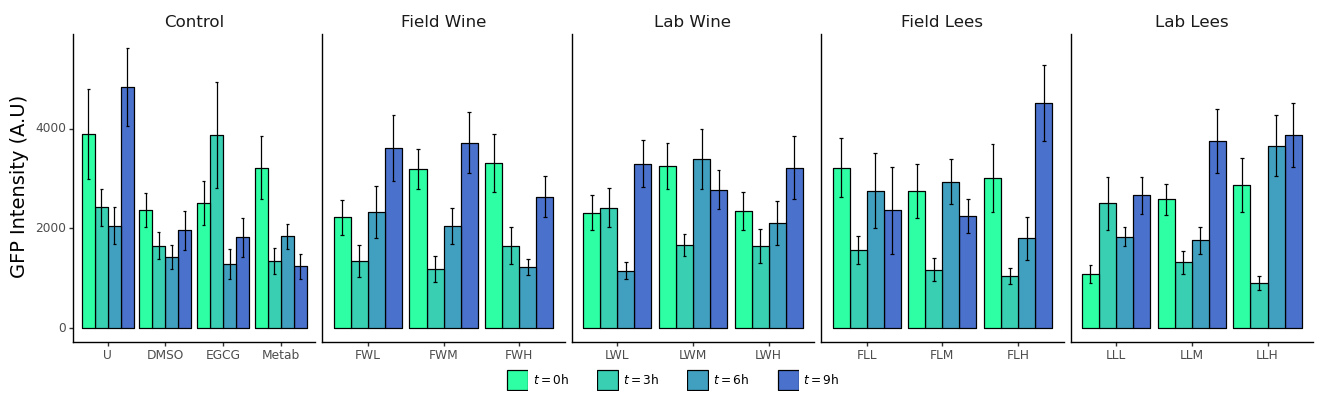

<ggplot: (329004788)>

In [748]:
## 2. Visualize the results and add panel grids per type

h = ( ggplot(all_df, aes(x='control_index', y='RawIntDen_mean', fill='time')) +\
        theme_classic()  + labs(x = '', y = 'GFP Intensity (A.U)') +\
        geom_bar(position=position_dodge(), stat="identity", colour='black') +\
        geom_errorbar(aes(ymin='RawIntDen_lower', ymax='RawIntDen_upper'), width=.2,position=position_dodge(.9)) +\
        # scale_x_discrete(limits=tandc) +\
        facet_grid('. ~ type', scales="free") +\
        theme(figure_size=(16, 4), legend_position = "bottom", legend_title = element_blank(), legend_entry_spacing_x = 20,
                axis_title_y = element_text(size = 14), axis_title_x = element_text(size = 14),
                strip_text_x = element_text(size=12), strip_background = element_blank(),
                axis_line_y = element_line(colour = 'black', linetype='solid')) +\
        scale_fill_manual(name = 'Toxin', values=gradient_scheme, labels=['$t = 0$h', '$t = 3$h', '$t = 6$h', '$t = 9$h'])
        
)
h

In [749]:
## Saving the graph
h.save(filename = '%s-Control-vs-Treatment.png'%strain, height=4.5, width=12, units = 'in', dpi=600, path=os.path.join(strain))
print("Saved file.")

/Users/jcbacong/opt/miniconda3/envs/meowth/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 12 x 4.5 in image.
/Users/jcbacong/opt/miniconda3/envs/meowth/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: OH441/OH441-Control-vs-Treatment.png


Saved file.


## 4. Normalization
Normalizing each group with respect to their control. 

In [750]:
t0_all = all_df[all_df.time=="t0"][["control","RawIntDen_mean", "RawIntDen_upper", "RawIntDen_lower"]].set_index("control").to_dict()
normalize = all_df.copy()
normalize["t0_mean"] = all_df.control.apply(lambda x: t0_all.get("RawIntDen_mean").get(x))
normalize["t0_upper"] = all_df.control.apply(lambda x: t0_all.get("RawIntDen_upper").get(x))
normalize["t0_lower"] = all_df.control.apply(lambda x: t0_all.get("RawIntDen_lower").get(x))

normalize["RawIntDen_mean_norm"] = normalize.RawIntDen_mean/normalize["t0_mean"]
normalize["RawIntDen_upper_norm"] = normalize.RawIntDen_upper/normalize["t0_upper"]
normalize["RawIntDen_lower_norm"] = normalize.RawIntDen_lower/normalize["t0_lower"]

normalize

,control,time,RawIntDen_mean,RawIntDen_sem,Mean_mean,Area_mean,RawIntDen_upper,RawIntDen_lower,type,control_index,t0_mean,t0_upper,t0_lower,RawIntDen_mean_norm,RawIntDen_upper_norm,RawIntDen_lower_norm
13,U,t3,2422.991150,374.931079,91.704035,21.522124,2797.922230,2048.060071,Control,U,3889.513514,4791.146183,2987.880844,0.622955,0.583978,0.685456
15,U,t9,4826.761194,784.692401,117.277313,32.194030,5611.453595,4042.068793,Control,U,3889.513514,4791.146183,2987.880844,1.240968,1.171213,1.352821
14,U,t6,2050.445312,370.444336,66.043078,22.882812,2420.889648,1680.000977,Control,U,3889.513514,4791.146183,2987.880844,0.527173,0.505284,0.562272
12,U,t0,3889.513514,901.632670,107.074919,29.648649,4791.146183,2987.880844,Control,U,3889.513514,4791.146183,2987.880844,1.000000,1.000000,1.000000
0,DMSO,t0,2370.372549,341.369688,92.755196,20.568627,2711.742237,2029.002861,Control,DMSO,2370.372549,2711.742237,2029.002861,1.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48,LLM,t0,2579.979452,312.956654,94.719267,23.054795,2892.936106,2267.022798,Lab Lees,LLM,2579.979452,2892.936106,2267.022798,1.000000,1.000000,1.000000
40,LLH,t0,2866.172840,546.003934,115.434000,20.913580,3412.176773,2320.168906,Lab Lees,LLH,2866.172840,3412.176773,2320.168906,1.000000,1.000000,1.000000
43,LLH,t9,3868.977778,637.223460,131.200144,24.644444,4506.201238,3231.754317,Lab Lees,LLH,2866.172840,3412.176773,2320.168906,1.349876,1.320624,1.392896
42,LLH,t6,3658.013699,604.522368,95.376822,29.767123,4262.536066,3053.491331,Lab Lees,LLH,2866.172840,3412.176773,2320.168906,1.276271,1.249213,1.316064


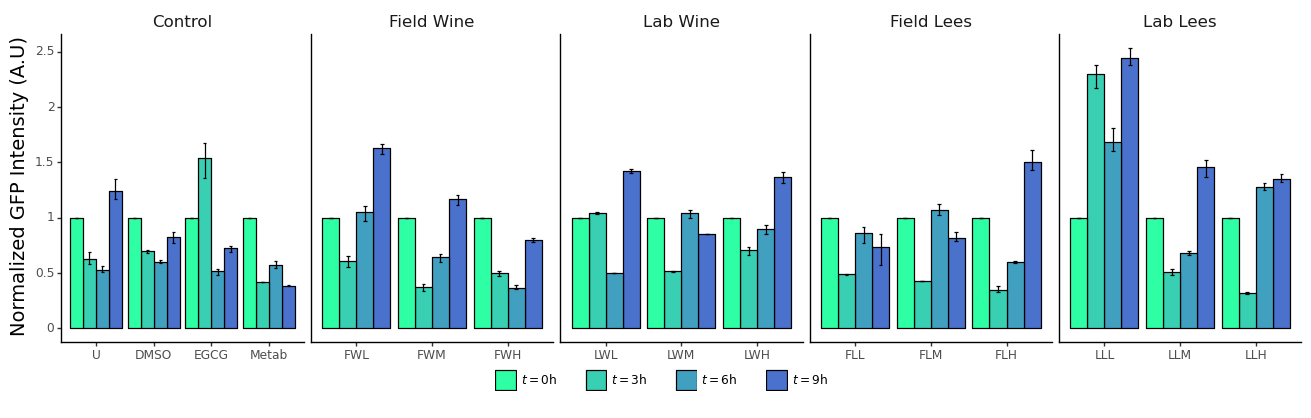

<ggplot: (323370442)>

In [751]:
## 2. Visualize the results and add panel grids per type

gradient_scheme = ["#2effa4", "#38cfb2", "#41a0bf", "#4a71cc"]

q = ( ggplot(normalize, aes(x='control_index', y='RawIntDen_mean_norm', fill='time')) +\
        theme_classic()  + labs(x = '', y = 'Normalized GFP Intensity (A.U)') +\
        geom_bar(position=position_dodge(), stat="identity", colour='black') +\
        geom_errorbar(aes(ymin='RawIntDen_lower_norm', ymax='RawIntDen_upper_norm'), width=.2,position=position_dodge(.9)) +\
        # scale_x_discrete(limits=tandc) +\
        facet_grid('. ~ type', scales="free") +\
        theme(figure_size=(16, 4), legend_position = "bottom", legend_title = element_blank(), legend_entry_spacing_x = 20,
                axis_title_y = element_text(size = 14), axis_title_x = element_text(size = 14),
                strip_text_x = element_text(size=12), strip_background = element_blank(),
                axis_line_y = element_line(colour = 'black', linetype='solid')) +\
        scale_fill_manual(name = 'Toxin', values=gradient_scheme, labels=['$t = 0$h', '$t = 3$h', '$t = 6$h', '$t = 9$h'])
        
)
q

In [752]:
## Saving the graph
q.save(filename = '%s-Control-vs-Treatment-Normalized.png'%strain, height=4.5, width=12, units = 'in', dpi=600, path=os.path.join(strain))
print("Saved file.")

/Users/jcbacong/opt/miniconda3/envs/meowth/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 12 x 4.5 in image.
/Users/jcbacong/opt/miniconda3/envs/meowth/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: OH441/OH441-Control-vs-Treatment-Normalized.png


Saved file.


In [753]:
## 2. Visualize the results and add panel grids per type
## As a line

gradient_scheme = ["#2effa4", "#38cfb2", "#41a0bf", "#4a71cc"]

def color_line_map(x):
        if len(x)!=3:
                return x
        else:
                if x[2] == "L":
                        return "Low"
                elif x[2] == "M":
                        return "Medium"
                else:
                        return "High"

def time_line_map(x):
        if x=='t0':
                return 0
        elif x=='t3':
                return 3
        elif x=='t6':
                return 6
        elif x=='t9':
                return 9
        else:
                return x

normalize["color"] = normalize.control.apply(lambda x: color_line_map(x))
normalize.color = pd.Categorical(normalize.color, categories = ['U', 'DMSO', 'EGCG', 'Metab', 'Low', 'Medium', 'High'])
normalize["time_no"] = normalize.time.apply(lambda x: time_line_map(x))
normalize

,control,time,RawIntDen_mean,RawIntDen_sem,Mean_mean,Area_mean,RawIntDen_upper,RawIntDen_lower,type,control_index,t0_mean,t0_upper,t0_lower,RawIntDen_mean_norm,RawIntDen_upper_norm,RawIntDen_lower_norm,color,time_no
13,U,t3,2422.991150,374.931079,91.704035,21.522124,2797.922230,2048.060071,Control,U,3889.513514,4791.146183,2987.880844,0.622955,0.583978,0.685456,U,3
15,U,t9,4826.761194,784.692401,117.277313,32.194030,5611.453595,4042.068793,Control,U,3889.513514,4791.146183,2987.880844,1.240968,1.171213,1.352821,U,9
14,U,t6,2050.445312,370.444336,66.043078,22.882812,2420.889648,1680.000977,Control,U,3889.513514,4791.146183,2987.880844,0.527173,0.505284,0.562272,U,6
12,U,t0,3889.513514,901.632670,107.074919,29.648649,4791.146183,2987.880844,Control,U,3889.513514,4791.146183,2987.880844,1.000000,1.000000,1.000000,U,0
0,DMSO,t0,2370.372549,341.369688,92.755196,20.568627,2711.742237,2029.002861,Control,DMSO,2370.372549,2711.742237,2029.002861,1.000000,1.000000,1.000000,DMSO,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48,LLM,t0,2579.979452,312.956654,94.719267,23.054795,2892.936106,2267.022798,Lab Lees,LLM,2579.979452,2892.936106,2267.022798,1.000000,1.000000,1.000000,Medium,0
40,LLH,t0,2866.172840,546.003934,115.434000,20.913580,3412.176773,2320.168906,Lab Lees,LLH,2866.172840,3412.176773,2320.168906,1.000000,1.000000,1.000000,High,0
43,LLH,t9,3868.977778,637.223460,131.200144,24.644444,4506.201238,3231.754317,Lab Lees,LLH,2866.172840,3412.176773,2320.168906,1.349876,1.320624,1.392896,High,9
42,LLH,t6,3658.013699,604.522368,95.376822,29.767123,4262.536066,3053.491331,Lab Lees,LLH,2866.172840,3412.176773,2320.168906,1.276271,1.249213,1.316064,High,6


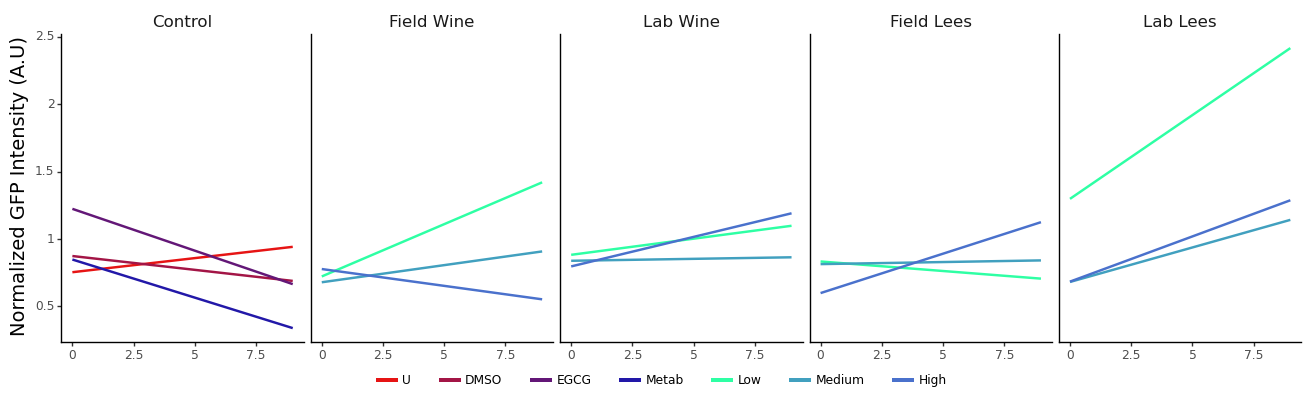

<ggplot: (326444406)>

In [754]:
## 2. Visualize as a line


q1 = ( ggplot(normalize, aes(x='time_no', y='RawIntDen_mean_norm', colour = 'color', group = 'control_index')) +\
        theme_classic()  + labs(x = '', y = 'Normalized GFP Intensity (A.U)') +\
        # geom_col(position=position_dodge(), stat="identity", colour='black') +\
        geom_smooth(method='lm', se=False, formula= "y ~ x + 1")+\
        # geom_errorbar(aes(ymin='RawIntDen_lower_norm', ymax='RawIntDen_upper_norm'), width=.2,position=position_dodge(.9)) +\
        # scale_x_discrete([0,3, 6, 9]) +\
        facet_grid('. ~ type', scales="free") +\
        theme(figure_size=(16, 4), legend_position = "bottom", legend_title = element_blank(), legend_entry_spacing_x = 20,
                axis_title_y = element_text(size = 14), axis_title_x = element_text(size = 14),
                strip_text_x = element_text(size=12), strip_background = element_blank(),
                axis_line_y = element_line(colour = 'black', linetype='solid')) +\
        scale_color_manual(values = [ "#e61414", "#a31546", "#631777", "#2218a8", "#2effa4", "#41a0bf", "#4a71cc"]) +\
        guides(colour = guide_legend(nrow = 1)) 
        # scale_fill_manual(name = 'Toxin', values=gradient_scheme, labels=['$t = 0$h', '$t = 3$h', '$t = 6$h', '$t = 9$h'])
        
)
q1

#### 4.b Linear Regression

In [755]:
from scipy.optimize import curve_fit
from scipy import stats
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
import numpy as np 

norm = normalize[["control",  "control_index", "type", "time_no", "RawIntDen_mean_norm"]]
b_intercept = 1
norm["y"] = norm.RawIntDen_mean_norm - b_intercept

slope = []
score = []

for ctrl in norm.control.unique():
    x = norm[norm.control == ctrl].time_no.to_list()
    y = norm[norm.control == ctrl].y.to_list()
    X = np.vstack([x]).T
    reg = LinearRegression(fit_intercept=False).fit(X,y)
    slope.append(tuple((ctrl, reg.coef_[0])))
    score.append(tuple((ctrl, reg.score(X,y))))

slope = dict(slope)
score = dict(score)
slope
            

/var/folders/13/n0z1468d69v4k2tj22bhlh800000gp/T/ipykernel_1738/1913370715.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


{'U': -0.014280863730764504,
 'DMSO': -0.03853757463853446,
 'EGCG': -0.03008622457697337,
 'Metab': -0.07823478250189861,
 'FWL': 0.03783630706564103,
 'FWM': -0.020432982021918168,
 'FWH': -0.056765175691098735,
 'LWL': 0.007151796289915431,
 'LWM': -0.020200508539148218,
 'LWH': 0.014711276815468275,
 'FLL': -0.03794046251903929,
 'FLM': -0.02354973978618816,
 'FLH': 0.001116590661679112,
 'LLL': 0.16665286847117208,
 'LLM': 0.00563584284046043,
 'LLH': 0.02185354174322546}

In [756]:
### Get regression parameters
normalize['y_fitted'] = normalize.apply(lambda x: slope.get(x["control"])*x["time_no"] + b_intercept, axis=1)
normalize

,control,time,RawIntDen_mean,RawIntDen_sem,Mean_mean,Area_mean,RawIntDen_upper,RawIntDen_lower,type,control_index,t0_mean,t0_upper,t0_lower,RawIntDen_mean_norm,RawIntDen_upper_norm,RawIntDen_lower_norm,color,time_no,y_fitted
13,U,t3,2422.991150,374.931079,91.704035,21.522124,2797.922230,2048.060071,Control,U,3889.513514,4791.146183,2987.880844,0.622955,0.583978,0.685456,U,3,0.957157
15,U,t9,4826.761194,784.692401,117.277313,32.194030,5611.453595,4042.068793,Control,U,3889.513514,4791.146183,2987.880844,1.240968,1.171213,1.352821,U,9,0.871472
14,U,t6,2050.445312,370.444336,66.043078,22.882812,2420.889648,1680.000977,Control,U,3889.513514,4791.146183,2987.880844,0.527173,0.505284,0.562272,U,6,0.914315
12,U,t0,3889.513514,901.632670,107.074919,29.648649,4791.146183,2987.880844,Control,U,3889.513514,4791.146183,2987.880844,1.000000,1.000000,1.000000,U,0,1.000000
0,DMSO,t0,2370.372549,341.369688,92.755196,20.568627,2711.742237,2029.002861,Control,DMSO,2370.372549,2711.742237,2029.002861,1.000000,1.000000,1.000000,DMSO,0,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48,LLM,t0,2579.979452,312.956654,94.719267,23.054795,2892.936106,2267.022798,Lab Lees,LLM,2579.979452,2892.936106,2267.022798,1.000000,1.000000,1.000000,Medium,0,1.000000
40,LLH,t0,2866.172840,546.003934,115.434000,20.913580,3412.176773,2320.168906,Lab Lees,LLH,2866.172840,3412.176773,2320.168906,1.000000,1.000000,1.000000,High,0,1.000000
43,LLH,t9,3868.977778,637.223460,131.200144,24.644444,4506.201238,3231.754317,Lab Lees,LLH,2866.172840,3412.176773,2320.168906,1.349876,1.320624,1.392896,High,9,1.196682
42,LLH,t6,3658.013699,604.522368,95.376822,29.767123,4262.536066,3053.491331,Lab Lees,LLH,2866.172840,3412.176773,2320.168906,1.276271,1.249213,1.316064,High,6,1.131121


/Users/jcbacong/opt/miniconda3/envs/meowth/lib/python3.9/site-packages/plotnine/guides/guides.py:187: PlotnineWarning: Cannot generate legend for the 'shape' aesthetic. Make sure you have mapped a variable to it


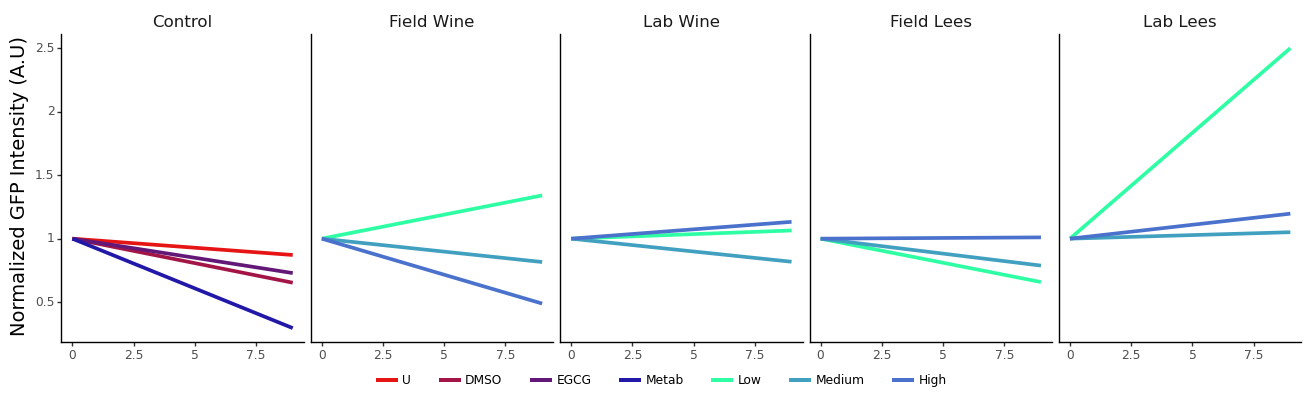

<ggplot: (334716793)>

In [757]:

q2 = ( ggplot(normalize, aes(x='time_no', y='y_fitted', colour = 'color', group = 'control_index')) +\
        geom_line(size=1.5)+\
        theme_classic()  + labs(x = '', y = 'Normalized GFP Intensity (A.U)') +\
        facet_grid('. ~ type', scales="free") +\
        theme(figure_size=(16, 4), legend_position = "bottom", legend_title = element_blank(), legend_entry_spacing_x = 20,
                axis_title_y = element_text(size = 14), axis_title_x = element_text(size = 14),
                strip_text_x = element_text(size=12), strip_background = element_blank(),
                axis_line_y = element_line(colour = 'black', linetype='solid')) +\
        scale_color_manual(values = [ "#e61414", "#a31546", "#631777", "#2218a8", "#2effa4", "#41a0bf", "#4a71cc"]) +\
        scale_shape_manual(values = [ "#e61414", "#a31546", "#631777", "#2218a8", "#2effa4", "#41a0bf", "#4a71cc"]) +\
        guides(colour = guide_legend(nrow = 1))        
)
q2

In [758]:
## Saving the graph
q1.save(filename = '%s-Control-vs-Treatment-Normalized-Line.png'%strain, height=4.5, width=12, units = 'in', dpi=600, path=os.path.join(strain))
print("Saved file.")

q2.save(filename = '%s-Control-vs-Treatment-Normalized-Fit-Line.png'%strain, height=4.5, width=12, units = 'in', dpi=600, path=os.path.join(strain))
print("Saved file.")

/Users/jcbacong/opt/miniconda3/envs/meowth/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 12 x 4.5 in image.
/Users/jcbacong/opt/miniconda3/envs/meowth/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: OH441/OH441-Control-vs-Treatment-Normalized-Line.png


Saved file.


/Users/jcbacong/opt/miniconda3/envs/meowth/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 12 x 4.5 in image.
/Users/jcbacong/opt/miniconda3/envs/meowth/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: OH441/OH441-Control-vs-Treatment-Normalized-Fit-Line.png
/Users/jcbacong/opt/miniconda3/envs/meowth/lib/python3.9/site-packages/plotnine/guides/guides.py:187: PlotnineWarning: Cannot generate legend for the 'shape' aesthetic. Make sure you have mapped a variable to it


Saved file.


## 5. Statistics
Since normality test failed, we used non-parametric statistical procedures. Take note that this has low statistical power. I would recommend to use GLMs. 

1. We check if control vs treatment (across 4 time points) is significantly different. (Two-way ANOVA with White correction for heterogenous variance)
2. We check if the median GFP intensity across multiple time points within the same group is significantly different. (Games-Howell post hoc test)

In [759]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

## Transform data using BoxCox
sgdf["RawIntDen_boxcox"],_ = boxcox(sgdf.RawIntDen)

tgdf["RawIntDen_boxcox"],_ = boxcox(tgdf.RawIntDen)

ctrl_df2 = sgdf.groupby(['control', 'time']).agg({'RawIntDen_boxcox': ['mean','sem'], 'Mean': ['mean'], 'Area': ['mean']}).reset_index()
ctrl_df2.columns = ctrl_df2.columns.map('_'.join)
ctrl_df2 = ctrl_df2.rename(columns={'control_': 'control', 'time_': 'time'})
ctrl_df2['RawIntDen_boxcox_upper'] = ctrl_df2.RawIntDen_boxcox_mean + ctrl_df2.RawIntDen_boxcox_sem
ctrl_df2['RawIntDen_boxcox_lower'] = ctrl_df2.RawIntDen_boxcox_mean - ctrl_df2.RawIntDen_boxcox_sem
ctrl_df2.loc[ctrl_df2.control=='OP50', 'control'] = 'U'

tx_df2 = tgdf.groupby(['control', 'time']).agg({'RawIntDen_boxcox': ['mean','sem'], 'Mean': ['mean'], 'Area': ['mean']}).reset_index()
tx_df2.columns = tx_df2.columns.map('_'.join)
tx_df2 = tx_df2.rename(columns={'control_': 'control', 'time_': 'time'})
tx_df2['RawIntDen_boxcox_upper'] = tx_df2.RawIntDen_boxcox_mean + tx_df2.RawIntDen_boxcox_sem
tx_df2['RawIntDen_boxcox_lower'] = tx_df2.RawIntDen_boxcox_mean - tx_df2.RawIntDen_boxcox_sem
tx_df2.control = tx_df2.control.apply(lambda x: x.upper())

ctrl_df2['type'] = 'Control'
tx_df2['type'] = tx_df2.control.apply(lambda x: rename_wine_or_lees(x))
all_df2 = pd.concat([ctrl_df2, tx_df2], axis=0).reset_index().drop("index", axis=1)
all_df2['control_index'] = pd.Categorical(
                            all_df2['control'], 
                            categories=tandc, 
                            ordered=True)
all_df2['type'] = pd.Categorical(
                            all_df2['type'], 
                            categories=["Control", "Field Wine", "Lab Wine", "Field Lees", "Lab Lees"], 
                            ordered=True)
                            
all_df2.sort_values('control_index', inplace=True)
all_df2


,control,time,RawIntDen_boxcox_mean,RawIntDen_boxcox_sem,Mean_mean,Area_mean,RawIntDen_boxcox_upper,RawIntDen_boxcox_lower,type,control_index
13,U,t3,3.464537,0.026815,91.704035,21.522124,3.491352,3.437722,Control,U
15,U,t9,3.589491,0.035576,117.277313,32.194030,3.625067,3.553916,Control,U
14,U,t6,3.398961,0.025797,66.043078,22.882812,3.424758,3.373164,Control,U
12,U,t0,3.564485,0.044529,107.074919,29.648649,3.609014,3.519956,Control,U
0,DMSO,t0,3.474379,0.027337,92.755196,20.568627,3.501716,3.447043,Control,DMSO
...,...,...,...,...,...,...,...,...,...,...
48,LLM,t0,3.680549,0.025109,94.719267,23.054795,3.705657,3.655440,Lab Lees,LLM
40,LLH,t0,3.710999,0.030529,115.434000,20.913580,3.741528,3.680470,Lab Lees,LLH
43,LLH,t9,3.754582,0.028888,131.200144,24.644444,3.783470,3.725694,Lab Lees,LLH
42,LLH,t6,3.717543,0.039343,95.376822,29.767123,3.756885,3.678200,Lab Lees,LLH


In [760]:

## OLS model
def rename_time(x):
    if x == "t0":
        return 1
    elif x == "t3":
        return 2
    elif x == "t6":
        return 3
    elif x == "t9":
        return 4

all_df2["anova_time"] =  all_df2.time.apply(lambda x: rename_time(x))
# all_df.head(10)
model = ols('RawIntDen_boxcox_mean ~ control_index + anova_time + control_index*anova_time', data = all_df2).fit()
anova_result = sm.stats.anova_lm(model, type=2, robust='hc3')
print("Strain :", strain)
anova_result




Strain : OH441


,df,sum_sq,mean_sq,F,PR(>F)
control_index,15.0,0.426518,0.028435,3.893042,0.000608
anova_time,1.0,0.011313,0.011313,1.548861,0.222342
control_index:anova_time,15.0,0.054308,0.003621,0.495698,0.924989
Residual,32.0,0.233726,0.007304,NaN,NaN
